In [178]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import pickle

In [179]:
X = pd.read_csv('training_set_values.csv', index_col = 0)

In [180]:
y = pd.read_csv('training_set_labels.csv', index_col = 0)

In [181]:
df = pd.concat([X, y], axis = 1)

In [5]:
classes = ['functional', 'functional needs repair', 'non functional']

#### remove: wpt_name, date_recorded, region_code, recorded_by, scheme_name, extraction_type, payment_type, water_quality, quantity_group, source

#### possibly to remove: funder, long/lat, num_private, installer, subvillage

#### Maybe: district_code, lga, ward, scheme_management/management, extraction_type_group, management_group

#### Dummies: Basin, region, public_meeting, permit, extraction_type_class, payment, quality_group, quantity, source_type, source_class, waterpoint_type_group

#### Continuous: amount_tsh, gps_height, population, construction_year (look at 0's)

In [6]:
df.drop(columns = ['wpt_name', 'date_recorded', 'region_code', 'recorded_by', 
                     'scheme_name', 'extraction_type', 'payment_type', 'water_quality', 
                     'quantity_group', 'source', 'waterpoint_type'], inplace = True)

In [104]:
df2 = df.drop(columns = ['funder', 'longitude', 'latitude', 'num_private', 
                         'installer', 'subvillage'])

In [105]:
df3 = df2.drop(columns = ['district_code', 'lga', 'ward', 'scheme_management', 'management', 
                          'extraction_type_group', 'management_group', 'construction_year'])

In [9]:
df3.dropna(inplace = True)

## Making Dummies

In [106]:
basin_dummies = pd.get_dummies(df3['basin'], prefix = 'basin_', drop_first = True)

region_dummies = pd.get_dummies(df3['region'], prefix = 'region_', drop_first = True)

extraction_dummies = pd.get_dummies(df3['extraction_type_class'], prefix = 'extraction_', 
                                    drop_first = True)

payment_dummies = pd.get_dummies(df3['payment'], prefix = 'payment_', drop_first = True)

quality_dummies = pd.get_dummies(df3['quality_group'], prefix = 'quality_', drop_first = True)

quantity_dummies = pd.get_dummies(df3['quantity'], prefix = 'quantity_', drop_first = True)

source_type_dummies = pd.get_dummies(df3['source_type'], prefix = 'source_type', 
                                     drop_first = True)

source_class_dummies = pd.get_dummies(df3['source_class'], prefix = 'source_class', 
                                      drop_first = True)

waterpoint_type_dummies = pd.get_dummies(df3['waterpoint_type_group'], prefix = 'waterpoint_type_',
                                       drop_first = True)

In [107]:
permit_dict = {True: 1,
               False: 0}

df3[['permit', 'public_meeting']] = df3[['permit', 'public_meeting']].replace(permit_dict)

In [108]:
status_dict = {'functional': 1, 
               'non functional': 0, 
               'functional needs repair': 2}

In [109]:
df3 = pd.concat([df3, waterpoint_type_dummies, source_class_dummies, source_type_dummies,
                basin_dummies, region_dummies, extraction_dummies, payment_dummies,
                quality_dummies, quantity_dummies], axis = 1)

In [110]:
df3.drop(columns = ['basin', 'region', 'extraction_type_class', 'payment', 'quality_group', 
                    'quantity', 'source_type', 'source_class', 'waterpoint_type_group'], inplace = True)

In [66]:
df3.shape

(53281, 68)

In [111]:
X3 = df3.drop(columns = ['status_group'], axis = 1)

In [112]:
y3 = df3['status_group']

In [18]:
y3.unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

## Basic_Model

In [113]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=23)

In [114]:
scaler3 = StandardScaler()
scaler3.fit(X3_train)
X3_train = pd.DataFrame(data=scaler3.transform(X3_train), columns = X3.columns)
X3_test = pd.DataFrame(data=scaler3.transform(X3_test), columns = X3.columns)

(39960, 67)

## KNN Model (Basic Set #1)

In [115]:
knn_df3 = KNeighborsClassifier()

In [116]:
knn_df3.fit(X3_train, y3_train)

y_pred_knn3 = knn_df3.predict(X3_test)
y_train_knn3 = knn_df3.predict(X3_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [117]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_knn3))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_knn3))

ValueError: Found input variables with inconsistent numbers of samples: [14850, 13321]

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[6091  222  880]
 [ 581  247  145]
 [1423  113 3619]]


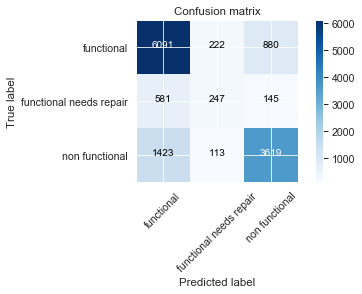

In [25]:
plot_confusion_matrix(metrics.confusion_matrix(y3_test, y_pred_knn3), classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Random Forest (Best set #2)

In [37]:
rfc_df3 = RandomForestClassifier(class_weight='balanced', criterion = 'entropy', max_depth = 16, 
                                 n_estimators = 200, random_state = 23, n_jobs = -1)

In [38]:
rfc_df3.fit(X3_train, y3_train)

y_pred_rfc3 = rfc_df3.predict(X3_test)
y_train_rfc3 = rfc_df3.predict(X3_train)

In [39]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_rfc3))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_rfc3))

Test Accuracy score:  0.7239696719465506
Train Accuracy score:  0.7985235235235235


### Random Forest Gridsearch 

In [29]:
params_df3 = {'max_depth': [3, 6, 9, 12, 15], 'n_estimators' : [100, 200, 300, 400, 500], 
              'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 
              'criterion': ['gini', 'entropy']} 

In [30]:
grid_df3 = GridSearchCV(rfc_df3, params_df3, verbose = 1, n_jobs = -1, cv = 5, scoring = 'accuracy')

grid_df3.fit(X3_train, y3_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s


KeyboardInterrupt: 

In [ ]:
grid_df3.best_estimator_

## XGB Model 

In [120]:
xgb_df3 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [122]:
xgb_df3.fit(X3_train, y3_train)

y_pred_xgb3 = xgb_df3.predict(X3_test)

y_train_xgb3 = xgb_df3.predict(X3_train)

In [123]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_xgb3))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_xgb3))

Test Accuracy score:  0.7812794612794612
Train Accuracy score:  0.8483950617283951


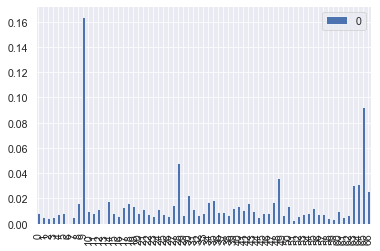

In [179]:
pd.DataFrame(xgb_df3.feature_importances_).plot.bar()

Index(['amount_tsh', 'gps_height', 'population', 'public_meeting', 'permit',
       'waterpoint_type__communal standpipe', 'waterpoint_type__dam',
       'waterpoint_type__hand pump', 'waterpoint_type__improved spring',
       'waterpoint_type__other', 'source_class_surface',
       'source_class_unknown', 'source_type_dam', 'source_type_other',
       'source_type_rainwater harvesting', 'source_type_river/lake',
       'source_type_shallow well', 'source_type_spring', 'basin__Lake Nyasa',
       'basin__Lake Rukwa', 'basin__Lake Tanganyika', 'basin__Lake Victoria',
       'basin__Pangani', 'basin__Rufiji', 'basin__Ruvuma / Southern Coast',
       'basin__Wami / Ruvu', 'region__Dar es Salaam', 'region__Dodoma',
       'region__Iringa', 'region__Kagera', 'region__Kigoma',
       'region__Kilimanjaro', 'region__Lindi', 'region__Manyara',
       'region__Mara', 'region__Mbeya', 'region__Morogoro', 'region__Mtwara',
       'region__Mwanza', 'region__Pwani', 'region__Rukwa', 'region__Ruvuma

## XGB Gridsearch

In [49]:
param_xgb = {'max_depth' : [4, 6, 8, 10], 'learning_rate' : [.01, .05, .1, .2], 
             'n_estimators' : [100, 250, 500], 'min_child_weight' : [1,3,5]}


In [51]:
grid_xgb = GridSearchCV(xgb_df3, param_xgb, n_jobs = -1, cv = 3, verbose = 1)

grid_xgb.fit(X3_train, y3_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 182.7min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=23,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, val

In [97]:
grid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [55]:
y_pred_xgb_grid = grid_xgb.best_estimator_.predict(X3_test)

In [57]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_xgb_grid))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_xgb3))

Test Accuracy score:  0.7781698070715412
Train Accuracy score:  0.8236486486486486


Confusion Matrix, without normalization
[[6444  141  608]
 [ 619  215  139]
 [1394   54 3707]]


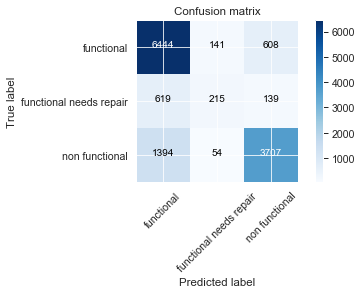

In [58]:
plot_confusion_matrix(metrics.confusion_matrix(y3_test, y_pred_xgb_grid), classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [264]:
test_df = pd.read_csv('Test_set_values.csv', index_col = 0)

In [265]:
installer_dummies = pd.get_dummies(test_df['installer'], prefix='installer')
installer_dummies = installer_dummies[['installer_DWE' , 'installer_Government']]

funder_dummies = pd.get_dummies(test_df['funder'], prefix='funder')
funder_dummies = funder_dummies[['funder_Hesawa' , 'funder_Danida', 'funder_Government Of Tanzania']]

subvillage_dummies = pd.get_dummies(test_df['subvillage'], prefix='subvillage')
subvillage_dummies = subvillage_dummies[['subvillage_Madukani' , 'subvillage_Shuleni', 'subvillage_Majengo']]

district_dummies = pd.get_dummies(test_df['district_code'], prefix='district')
district_dummies = district_dummies[['district_1' , 'district_2', 'district_3', 'district_4']]

test_df['construction_year'] = [0 if x == 0 else 1 if x <= 1990 else 2 for x in test_df['construction_year']]
year_dummies = pd.get_dummies(test_df['construction_year'], prefix='construction_year', drop_first=True)

lga_dummies = pd.get_dummies(test_df['lga'], prefix='lga')

lga_dummies = lga_dummies[['lga_Njombe',          
                            'lga_Arusha Rural',
                            'lga_Moshi Rural',   
                            'lga_Bariadi',         
                            'lga_Rungwe',         
                            'lga_Kilosa',         
                            'lga_Kasulu',          
                            'lga_Mbozi',           
                            'lga_Meru',            
                            'lga_Bagamoyo' ]]

basin_dummies = pd.get_dummies(test_df['basin'], prefix = 'basin_', drop_first = True)

region_dummies = pd.get_dummies(test_df['region'], prefix = 'region_', drop_first = True)

extraction_dummies = pd.get_dummies(test_df['extraction_type_class'], prefix = 'extraction_', 
                                    drop_first = True)

payment_dummies = pd.get_dummies(test_df['payment'], prefix = 'payment_', drop_first = True)

quality_dummies = pd.get_dummies(test_df['quality_group'], prefix = 'quality_', drop_first = True)

quantity_dummies = pd.get_dummies(test_df['quantity'], prefix = 'quantity_', drop_first = True)

source_type_dummies = pd.get_dummies(test_df['source_type'], prefix = 'source_type', 
                                     drop_first = True)

source_class_dummies = pd.get_dummies(test_df['source_class'], prefix = 'source_class', 
                                      drop_first = True)

waterpoint_type_dummies = pd.get_dummies(test_df['waterpoint_type_group'], prefix = 'waterpoint_type_',
                                       drop_first = True)

permit_dict = {True: 1,
               False: 0}

test_df[['permit', 'public_meeting']] = test_df[['permit', 'public_meeting']].replace(permit_dict)

test_df = pd.concat([test_df, waterpoint_type_dummies, source_class_dummies, source_type_dummies,
                     basin_dummies, region_dummies, extraction_dummies, payment_dummies,
                     quality_dummies, quantity_dummies, funder_dummies, installer_dummies, 
                     subvillage_dummies, district_dummies,lga_dummies, year_dummies], axis = 1)

test_df.drop(columns = ['wpt_name', 'date_recorded', 'region_code', 'recorded_by', 
                   'scheme_name', 'extraction_type', 'payment_type', 'water_quality', 
                   'quantity_group', 'source', 'waterpoint_type', 'funder', 'longitude', 
                   'latitude', 'num_private', 'installer', 'subvillage', 'district_code', 
                   'lga', 'scheme_management', 'extraction_type_group', 'construction_year', 
                   'basin', 'region', 'extraction_type_class', 'payment', 'quality_group', 
                   'quantity','source_type', 'source_class', 'waterpoint_type_group'], inplace = True)

test_df['ward'] = np.where(test_df['ward'] == 'Mishamo', 1, 0)
test_df['management'] = np.where(test_df['management'] == 'vwc', 1, 0)
test_df['management_group'] = np.where(test_df['management_group'] == 'user-group', 1, 0)

In [266]:

id_df = test_df.reset_index()['id']

In [163]:
#test_df = pd.DataFrame(data=scaler3.transform(test_df), columns = test_df.columns)

In [267]:
test_results = xgb_df.predict(test_df)


In [268]:
testing_results = pd.DataFrame(test_results, columns = ['status_group'])

In [269]:
test_labels = pd.concat([id_df, testing_results], axis = 1)

In [270]:
test_labels = test_labels.set_index('id')

In [275]:
test_labels['status_group'].value_counts()

functional                 9222
non functional             5134
functional needs repair     494
Name: status_group, dtype: int64

In [272]:
test_labels.to_csv('testing_results_ver2.csv')

Figuring out how to differentiate the predictions more:

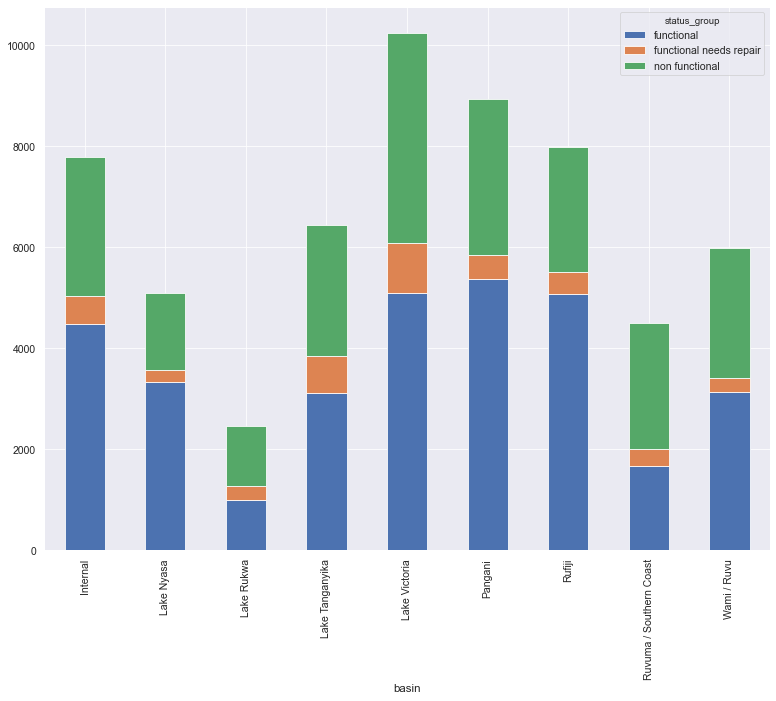

In [34]:
df.groupby('basin')['status_group'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(13,10))
plt.show()

In [72]:
df[['funder', 'status_group']]

,funder,status_group
id,,
69572,Roman,functional
8776,Grumeti,functional
34310,Lottery Club,functional
67743,Unicef,non functional
19728,Action In A,functional
...,...,...
60739,Germany Republi,functional
27263,Cefa-njombe,functional
37057,NaN,functional


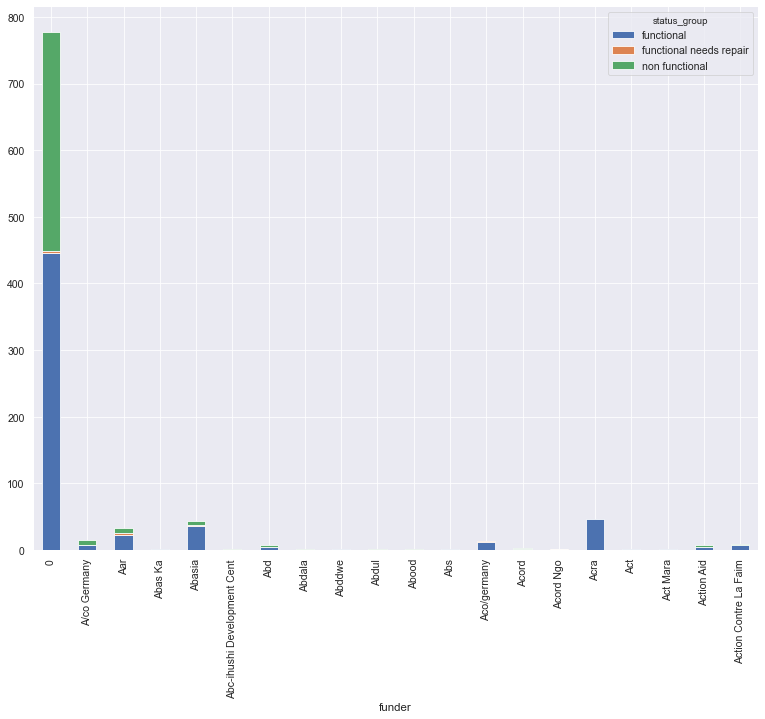

In [63]:
df.groupby('funder')['status_group'].value_counts().sort_values(ascending=False).unstack().head(20).plot(kind='bar', stacked=True, figsize=(13,10))
plt.show()

In [ ]:
#Government Of Tanzania, Danida, Hesawa

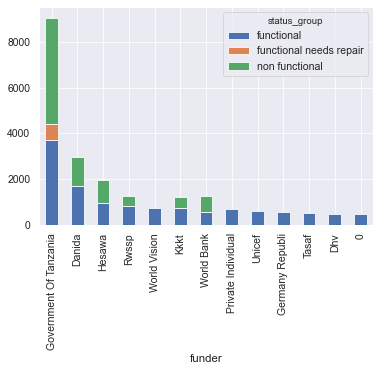

In [73]:
df.groupby('funder')['status_group'].value_counts().sort_values(ascending = False).head(20).unstack().plot(kind = 'bar', stacked = True)

In [ ]:
#DWE, Government

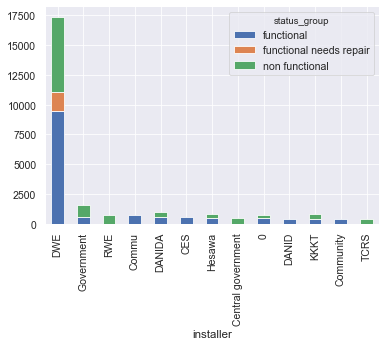

In [74]:
df.groupby('installer')['status_group'].value_counts().sort_values(ascending = False).head(20).unstack().plot(kind = 'bar', stacked = True)

In [ ]:
#Madukani, Majengo, Shuleni

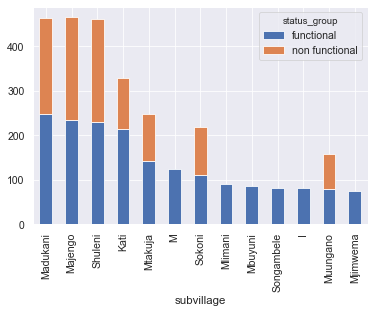

In [75]:
df.groupby('subvillage')['status_group'].value_counts().sort_values(ascending = False).head(20).unstack().plot(kind = 'bar', stacked = True)

In [ ]:
#1,2,3,4

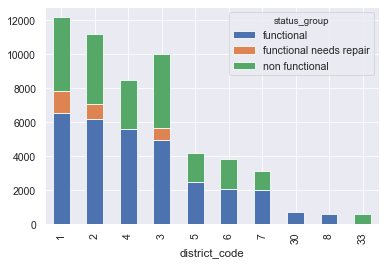

In [77]:
df.groupby('district_code')['status_group'].value_counts().sort_values(ascending = False).head(20).unstack().plot(kind = 'bar', stacked = True)

In [80]:
df['lga'].nunique()

125

In [ ]:
#Top 10 LGA   -check coefficients after

In [88]:
df.groupby('lga').count().sort_values(by='status_group', ascending=False).head(10)

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,...,extraction_type_class,management,management_group,payment,quality_group,quantity,source_type,source_class,waterpoint_type_group,status_group
lga,,,,,,,,,,,,,,,,,,,,,
Njombe,2503,2500,2503,2502,2503,2503,2503,2503,2503,2503,...,2503,2503,2503,2503,2503,2503,2503,2503,2503,2503
Arusha Rural,1252,1204,1252,1206,1252,1252,1252,1252,1252,1252,...,1252,1252,1252,1252,1252,1252,1252,1252,1252,1252
Moshi Rural,1251,1249,1251,1249,1251,1251,1251,1251,1251,1251,...,1251,1251,1251,1251,1251,1251,1251,1251,1251,1251
Bariadi,1177,1168,1177,1166,1177,1177,1177,1177,1177,1177,...,1177,1177,1177,1177,1177,1177,1177,1177,1177,1177
Rungwe,1106,0,1106,0,1106,1106,1106,1106,1106,1106,...,1106,1106,1106,1106,1106,1106,1106,1106,1106,1106
Kilosa,1094,1088,1094,1088,1094,1094,1094,1094,1094,1094,...,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094
Kasulu,1047,1043,1047,1042,1047,1047,1047,1047,1047,1047,...,1047,1047,1047,1047,1047,1047,1047,1047,1047,1047
Mbozi,1034,1034,1034,1034,1034,1034,1034,1034,1034,1034,...,1034,1034,1034,1034,1034,1034,1034,1034,1034,1034
Meru,1009,1006,1009,1006,1009,1009,1009,1009,1009,1009,...,1009,1009,1009,1009,1009,1009,1009,1009,1009,1009


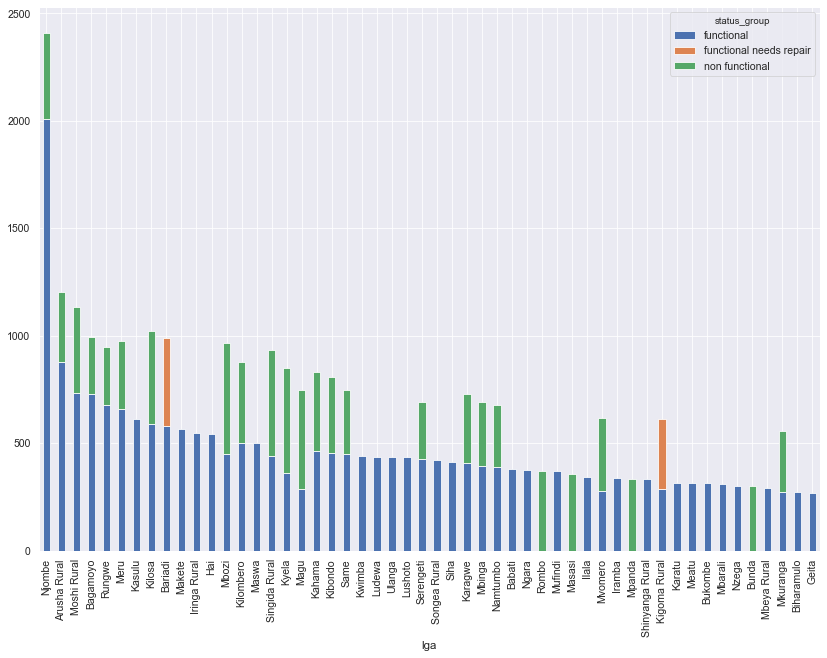

In [84]:
df.groupby('lga')['status_group'].value_counts().sort_values(ascending = False).head(75).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

In [ ]:
#Mishamo

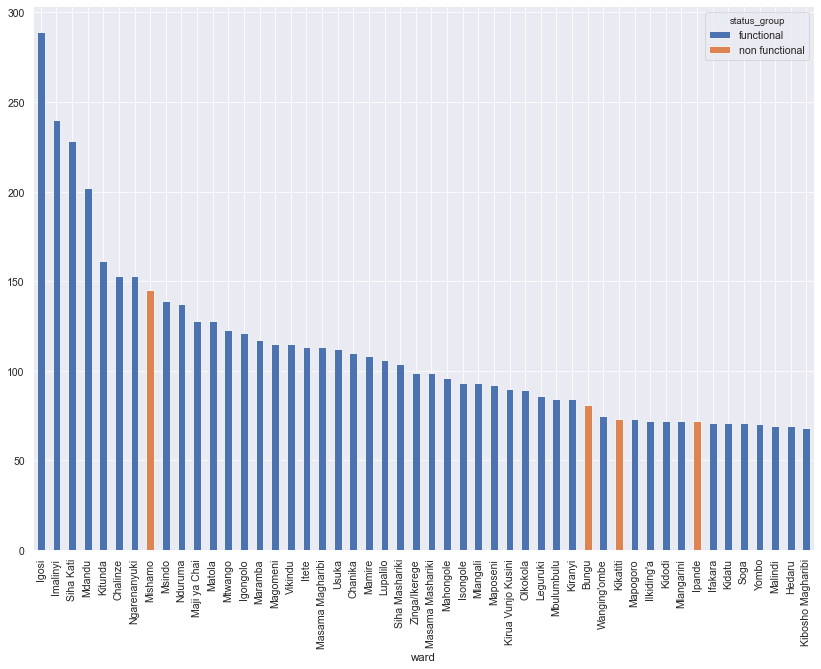

In [90]:
df.groupby('ward')['status_group'].value_counts().sort_values(ascending = False).head(50).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

In [ ]:
#VWC

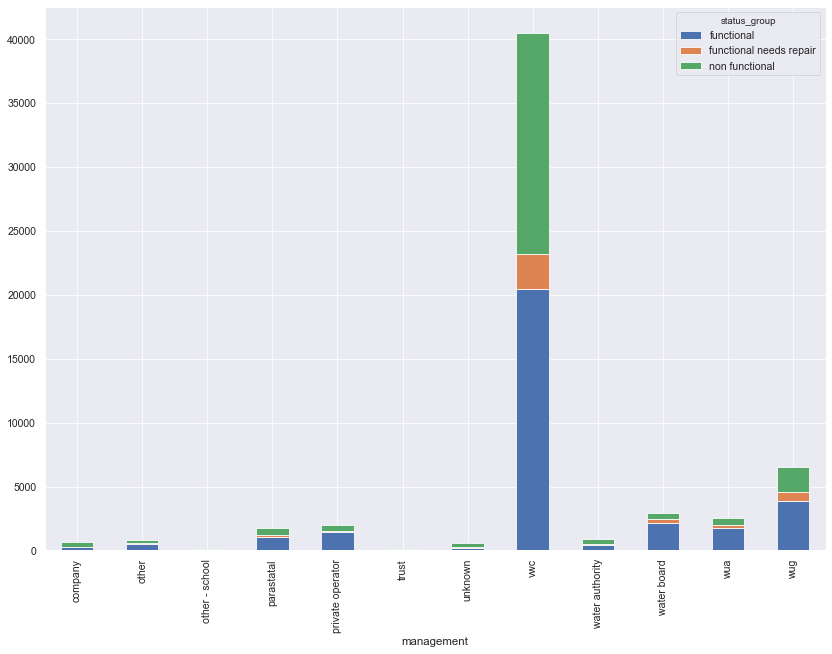

In [91]:
df.groupby('management')['status_group'].value_counts().sort_values(ascending = False).head(50).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

In [ ]:
#user-group

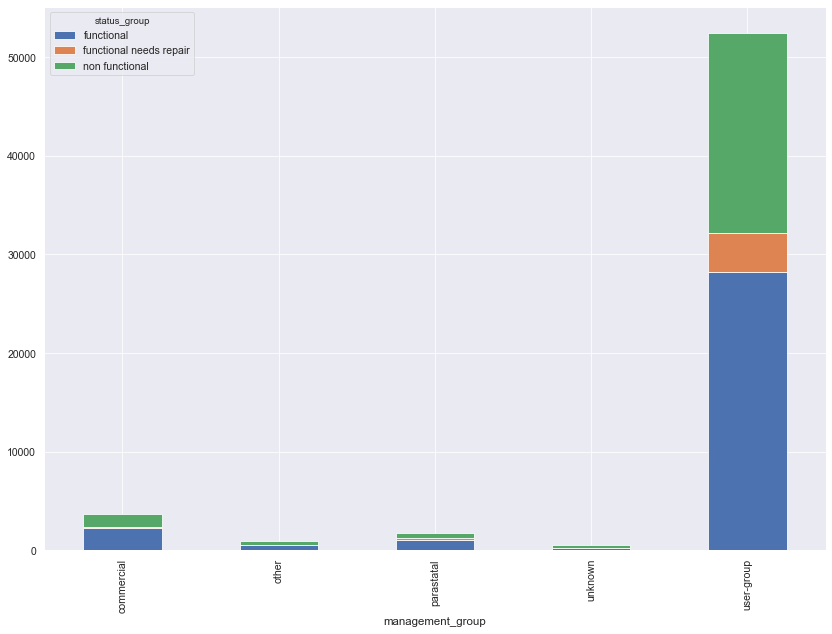

In [94]:
df.groupby('management_group')['status_group'].value_counts().sort_values(ascending = False).head(50).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

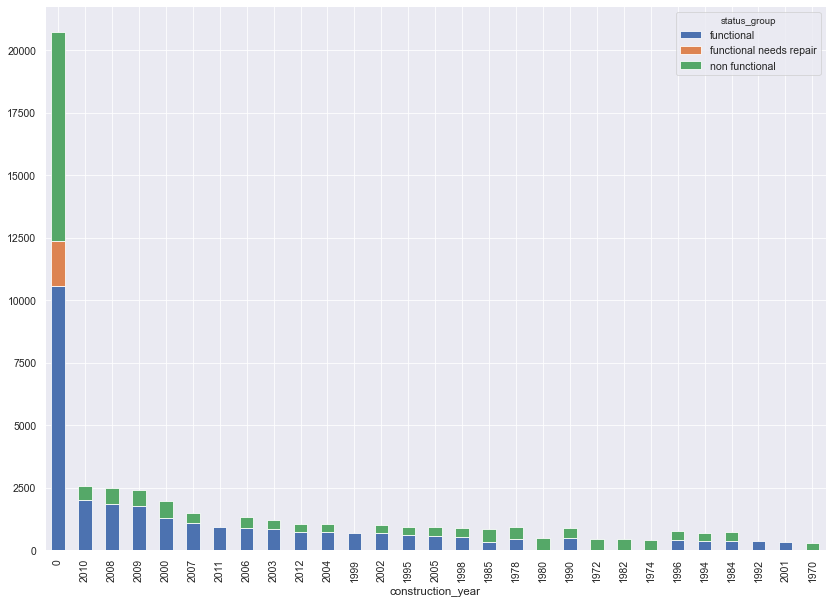

In [95]:
df.groupby('construction_year')['status_group'].value_counts().sort_values(ascending = False).head(50).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

In [ ]:
# 0 = 0 , less than 1990 = 1 , greater than 1990 = 2

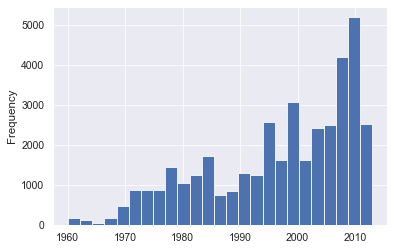

In [99]:
df[df['construction_year'] > 1 ]['construction_year'].plot(kind='hist', bins= 25)

status_group
functional                 AxesSubplot(0.125,0.125;0.775x0.755)
functional needs repair    AxesSubplot(0.125,0.125;0.775x0.755)
non functional             AxesSubplot(0.125,0.125;0.775x0.755)
Name: construction_year, dtype: object

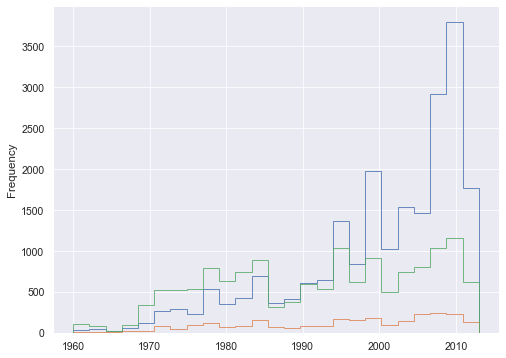

In [105]:
df[df['construction_year'] > 1 ].groupby('status_group')['construction_year'].plot(kind='hist', histtype='step', bins= 25, figsize=(8,6))

In [110]:
df[df['construction_year'] == 0]['status_group'].value_counts()

functional                 10555
non functional              8365
functional needs repair     1789
Name: status_group, dtype: int64

In [ ]:
#Funder Dummies

In [119]:
funder_dummies = pd.get_dummies(df['funder'], prefix='funder')

In [122]:
funder_dummies = funder_dummies[['funder_Hesawa' , 'funder_Danida', 'funder_Government Of Tanzania']]

In [120]:
funder_dummies.sum().sort_values()

funder_Mganga                       1
funder_Mwinjuma Mzee                1
funder_Mwingereza                   1
funder_Mwanza                       1
funder_Mwanamisi Ally               1
                                 ... 
funder_World Bank                1349
funder_Rwssp                     1374
funder_Hesawa                    2202
funder_Danida                    3114
funder_Government Of Tanzania    9084
Length: 1897, dtype: int64

In [125]:
#Installer Dummies

In [126]:
installer_dummies = pd.get_dummies(df['installer'], prefix='installer')

In [127]:
installer_dummies = installer_dummies[['installer_DWE' , 'installer_Government']]

In [129]:
installer_dummies.sum()

installer_DWE           17402
installer_Government     1825
dtype: int64

In [130]:
#subvillage

In [131]:
subvillage_dummies = pd.get_dummies(df['subvillage'], prefix='subvillage')

In [135]:
subvillage_dummies = subvillage_dummies[['subvillage_Madukani' , 'subvillage_Shuleni', 'subvillage_Majengo']]

In [136]:
subvillage_dummies.sum().sort_values()

subvillage_Majengo     502
subvillage_Shuleni     506
subvillage_Madukani    508
dtype: int64

In [137]:
#district code

In [138]:
district_dummies = pd.get_dummies(df['district_code'], prefix='district')

In [139]:
district_dummies = district_dummies[['district_1' , 'district_2', 'district_3', 'district_4']]

In [140]:
district_dummies.sum()

district_1    12203
district_2    11173
district_3     9998
district_4     8999
dtype: int64

In [141]:
#lga

In [142]:
lga_dummies = pd.get_dummies(df['lga'], prefix='lga')


In [151]:
lga_dummies = lga_dummies[['lga_Njombe',          
                            'lga_Arusha Rural',
                            'lga_Moshi Rural',   
                            'lga_Bariadi',         
                            'lga_Rungwe',         
                            'lga_Kilosa',         
                            'lga_Kasulu',          
                            'lga_Mbozi',           
                            'lga_Meru',            
                            'lga_Bagamoyo' ]]

In [154]:
lga_dummies

,lga_Njombe,lga_Arusha Rural,lga_Moshi Rural,lga_Bariadi,lga_Rungwe,lga_Kilosa,lga_Kasulu,lga_Mbozi,lga_Meru,lga_Bagamoyo
id,,,,,,,,,,
69572,0,0,0,0,0,0,0,0,0,0
8776,0,0,0,0,0,0,0,0,0,0
34310,0,0,0,0,0,0,0,0,0,0
67743,0,0,0,0,0,0,0,0,0,0
19728,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
60739,0,0,0,0,0,0,0,0,0,0
27263,1,0,0,0,0,0,0,0,0,0
37057,0,0,0,0,0,0,0,0,0,0


In [155]:
#ward

In [160]:
df['ward'].value_counts().sort_values(ascending=False).head(10)

Igosi           307
Imalinyi        252
Siha Kati       232
Mdandu          231
Nduruma         217
Kitunda         203
Mishamo         203
Msindo          201
Chalinze        196
Maji ya Chai    190
Name: ward, dtype: int64

In [184]:
df['ward'] = np.where(df['ward'] == 'Mishamo', 1, 0)

In [163]:
df['ward']

id
69572    0
8776     0
34310    0
67743    0
19728    0
        ..
60739    0
27263    0
37057    0
31282    0
26348    0
Name: ward, Length: 59400, dtype: int64

In [ ]:
#Management

In [185]:
df['management'] = np.where(df['management'] == 'vwc', 1, 0)

In [166]:
df['management']

id
69572    1
8776     0
34310    1
67743    1
19728    0
        ..
60739    0
27263    1
37057    1
31282    1
26348    1
Name: management, Length: 59400, dtype: int64

In [167]:
#Management Group

In [186]:
df['management_group'] = np.where(df['management_group'] == 'user-group', 1, 0)

In [170]:
df['management_group']

id
69572    1
8776     1
34310    1
67743    1
19728    0
        ..
60739    1
27263    1
37057    1
31282    1
26348    1
Name: management_group, Length: 59400, dtype: int64

In [171]:
#Construction Year

In [173]:
df['construction_year'] = [0 if x == 0 else 1 if x <= 1990 else 2 for x in df['construction_year']]


In [175]:
year_dummies = pd.get_dummies(df['construction_year'], prefix='construction_year', drop_first=True)

In [176]:
year_dummies

,construction_year_1,construction_year_2
id,,
69572,0,1
8776,0,1
34310,0,1
67743,1,0
19728,0,0
...,...,...
60739,0,1
27263,0,1
37057,0,0


In [ ]:
funder_dummies, installer_dummies, subvillage_dummies, district_dummies,lga_dummies, year_dummies

In [182]:
installer_dummies = pd.get_dummies(df['installer'], prefix='installer')
installer_dummies = installer_dummies[['installer_DWE' , 'installer_Government']]

funder_dummies = pd.get_dummies(df['funder'], prefix='funder')
funder_dummies = funder_dummies[['funder_Hesawa' , 'funder_Danida', 'funder_Government Of Tanzania']]

subvillage_dummies = pd.get_dummies(df['subvillage'], prefix='subvillage')
subvillage_dummies = subvillage_dummies[['subvillage_Madukani' , 'subvillage_Shuleni', 'subvillage_Majengo']]

district_dummies = pd.get_dummies(df['district_code'], prefix='district')
district_dummies = district_dummies[['district_1' , 'district_2', 'district_3', 'district_4']]

df['construction_year'] = [0 if x == 0 else 1 if x <= 1990 else 2 for x in df['construction_year']]
year_dummies = pd.get_dummies(df['construction_year'], prefix='construction_year', drop_first=True)

lga_dummies = pd.get_dummies(df['lga'], prefix='lga')

lga_dummies = lga_dummies[['lga_Njombe',          
                            'lga_Arusha Rural',
                            'lga_Moshi Rural',   
                            'lga_Bariadi',         
                            'lga_Rungwe',         
                            'lga_Kilosa',         
                            'lga_Kasulu',          
                            'lga_Mbozi',           
                            'lga_Meru',            
                            'lga_Bagamoyo' ]]

basin_dummies = pd.get_dummies(df['basin'], prefix = 'basin_', drop_first = True)

region_dummies = pd.get_dummies(df['region'], prefix = 'region_', drop_first = True)

extraction_dummies = pd.get_dummies(df['extraction_type_class'], prefix = 'extraction_', 
                                    drop_first = True)

payment_dummies = pd.get_dummies(df['payment'], prefix = 'payment_', drop_first = True)

quality_dummies = pd.get_dummies(df['quality_group'], prefix = 'quality_', drop_first = True)

quantity_dummies = pd.get_dummies(df['quantity'], prefix = 'quantity_', drop_first = True)

source_type_dummies = pd.get_dummies(df['source_type'], prefix = 'source_type', 
                                     drop_first = True)

source_class_dummies = pd.get_dummies(df['source_class'], prefix = 'source_class', 
                                      drop_first = True)

waterpoint_type_dummies = pd.get_dummies(df['waterpoint_type_group'], prefix = 'waterpoint_type_',
                                       drop_first = True)

permit_dict = {True: 1,
               False: 0}

df[['permit', 'public_meeting']] = df[['permit', 'public_meeting']].replace(permit_dict)

df = pd.concat([df, waterpoint_type_dummies, source_class_dummies, source_type_dummies,
                     basin_dummies, region_dummies, extraction_dummies, payment_dummies,
                     quality_dummies, quantity_dummies, funder_dummies, installer_dummies, 
                     subvillage_dummies, district_dummies,lga_dummies, year_dummies], axis = 1)

df.drop(columns = ['wpt_name', 'date_recorded', 'region_code', 'recorded_by', 
                   'scheme_name', 'extraction_type', 'payment_type', 'water_quality', 
                   'quantity_group', 'source', 'waterpoint_type', 'funder', 'longitude', 
                   'latitude', 'num_private', 'installer', 'subvillage', 'district_code', 
                   'lga', 'scheme_management', 'extraction_type_group', 'construction_year', 
                   'basin', 'region', 'extraction_type_class', 'payment', 'quality_group', 
                   'quantity','source_type', 'source_class', 'waterpoint_type_group'], inplace = True)

df['ward'] = np.where(df['ward'] == 'Mishamo', 1, 0)
df['management'] = np.where(df['management'] == 'vwc', 1, 0)
df['management_group'] = np.where(df['management_group'] == 'user-group', 1, 0)

In [190]:
df.isnull().sum().sort_values(ascending=False)

public_meeting            3334
permit                    3056
construction_year_2          0
region__Kilimanjaro          0
basin__Pangani               0
                          ... 
quality__salty               0
quality__unknown             0
quantity__enough             0
quantity__insufficient       0
amount_tsh                   0
Length: 95, dtype: int64

In [256]:
#XGBOOST MODEL

In [257]:
xgb_df = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)


In [258]:
X = df.drop('status_group', axis=1)
y = df['status_group']

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, test_size = .25) 

In [276]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns = X.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns = X.columns)

In [277]:
xgb_df.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [278]:
y_pred_xgb = xgb_df.predict(X_test)

In [279]:
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_xgb))

Test Accuracy score:  0.7928619528619528


In [ ]:
#First Logistic Regression to Fill in permit and public

In [204]:
x_log = df.drop(columns = ['permit', 'public_meeting', 'status_group'], axis=1)

In [216]:
x_permit_test = df[df['permit'].isnull() == True].drop(columns = ['permit', 'public_meeting', 'status_group'], axis=1)

In [217]:
x_public_test = df[df['public_meeting'].isnull() == True].drop(columns = ['permit', 'public_meeting', 'status_group'], axis=1)

In [206]:
y_permit = df[df['permit'].isnull() == False]['permit']

In [207]:
y_public = df[df['public_meeting'].isnull() == False]['public_meeting']

In [208]:
#balance the row number

In [211]:
x_permit = df[df['permit'].isnull() == False].drop(columns = ['permit', 'public_meeting', 'status_group'], axis=1)

In [213]:
x_public = df[df['public_meeting'].isnull() == False].drop(columns = ['permit', 'public_meeting', 'status_group'], axis=1)

In [214]:
x_public.shape

(56066, 92)

In [215]:
y_public.shape

(56066,)

In [ ]:
#permit logreg

In [218]:
df['permit'].value_counts()

1.0    38852
0.0    17492
Name: permit, dtype: int64

In [238]:
X1_train, X1_test, y1_train, y1_test = train_test_split(x_permit, y_permit, random_state = 20, test_size = .25) 

In [280]:
log_params = {'penalty': ['l1', 'l2'],
             'tol': [.0001, .001, .01, .1],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'C': [.01, .1, 1],
             'max_iter': [100, 500 ,1000]}

In [289]:
permit_log =  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [282]:
grid_search1 = GridSearchCV(permit_log, log_params, cv=3, verbose=1, n_jobs= -1)

In [284]:
grid_search1.fit(X1_train,y1_train)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 63.5min finished
/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'max_iter': [100, 500, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.0001, 0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', re

In [283]:
#permit_log.fit(X1_train, y1_train)

In [286]:
Xgrid_preds = grid_search1.best_estimator_.predict(X1_test)

In [288]:
grid_search1.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [287]:
accuracy_score(y1_test, Xgrid_preds)

0.7875195229305694

In [290]:
#public log

In [291]:
X2_train, X2_test, y2_train, y2_test = train_test_split(x_public, y_public, random_state = 20, test_size = .25) 

In [292]:
public_log =  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [293]:
public_log.fit(X2_train, y2_train)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [294]:
public_train_preds = public_log.predict(X2_train)
public_test_preds = public_log.predict(X2_test)

In [295]:
print(accuracy_score(y2_train, public_train_preds))
print(accuracy_score(y2_test, public_test_preds))

0.799709862303503
0.7998858528929157


In [296]:
#Predictions - Actual/


In [310]:
x_public_test

,amount_tsh,gps_height,ward,population,management,management_group,waterpoint_type__communal standpipe,waterpoint_type__dam,waterpoint_type__hand pump,waterpoint_type__improved spring,...,lga_Moshi Rural,lga_Bariadi,lga_Rungwe,lga_Kilosa,lga_Kasulu,lga_Mbozi,lga_Meru,lga_Bagamoyo,construction_year_1,construction_year_2
id,,,,,,,,,,,,,,,,,,,,,
8776,0.0,1399,0,280,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34169,0.0,1162,0,1000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6091,0.0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
24593,0.0,1703,0,456,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
35715,0.0,1565,0,200,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71419,0.0,1296,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
32815,0.0,892,0,65,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
748,0.0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [298]:
x_public_test , x_permit_test

In [299]:
public_values = public_log.predict(x_public_test)


In [320]:
pub_df = pd.DataFrame(public_values)

In [321]:
pub_df

,0
0,0.0
1,1.0
2,0.0
3,1.0
4,0.0
...,...
3329,0.0
3330,0.0
3331,0.0
3332,1.0


In [323]:
x_public_test.reset_index(inplace=True)

In [324]:
pub_df = pd.concat([x_public_test, pub_df], axis=1)

In [329]:
pub_df.rename(columns={0: 'public_meeting'}, inplace=True)

In [304]:
permit_values = permit_log.predict(x_permit_test)

array([1., 1., 1., ..., 1., 1., 1.])

In [349]:
perm_df = pd.DataFrame(permit_values)

In [330]:
#perm_df

In [331]:
x_permit_test.reset_index(inplace=True)

In [362]:
perm_df = pd.concat([x_permit_test, perm_df], axis=1)

In [363]:
perm_df.rename(columns={0:'permit'}, inplace=True)

In [360]:
df2  = df.reset_index()

In [335]:
pub_df

,id,amount_tsh,gps_height,ward,population,management,management_group,waterpoint_type__communal standpipe,waterpoint_type__dam,waterpoint_type__hand pump,...,lga_Bariadi,lga_Rungwe,lga_Kilosa,lga_Kasulu,lga_Mbozi,lga_Meru,lga_Bagamoyo,construction_year_1,construction_year_2,public_meeting
0,8776,0.0,1399,0,280,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0.0
1,34169,0.0,1162,0,1000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
2,6091,0.0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0.0
3,24593,0.0,1703,0,456,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1.0
4,35715,0.0,1565,0,200,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,71419,0.0,1296,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
3330,32815,0.0,892,0,65,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3331,748,0.0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0.0
3332,6450,0.0,1303,0,230,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1.0


In [380]:
df['permit'].fillna(perm_df, inplace = True)

In [373]:
df['public_meeting'].fillna(pub_df, inplace = True)

In [366]:
perm_df = perm_df.set_index('id')['permit']

In [370]:
pub_df = pub_df.set_index('id')['public_meeting']

In [ ]:
# XGB with imputed values

In [382]:
df.isnull().sum().sum()

0

In [383]:
xgb_df = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

X = df.drop('status_group', axis=1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, test_size = .25) 

xgb_df.fit(X_train, y_train)

y_pred_xgb = xgb_df.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, y_pred_xgb))

Test Accuracy score:  0.7953535353535354


In [384]:
test_df

,amount_tsh,gps_height,ward,population,public_meeting,permit,management,management_group,waterpoint_type__communal standpipe,waterpoint_type__dam,...,lga_Moshi Rural,lga_Bariadi,lga_Rungwe,lga_Kilosa,lga_Kasulu,lga_Mbozi,lga_Meru,lga_Bagamoyo,construction_year_1,construction_year_2
id,,,,,,,,,,,,,,,,,,,,,
50785,0.0,1996,0,321,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
51630,0.0,1569,0,300,1.0,1.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
17168,0.0,1567,0,500,1.0,NaN,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
45559,0.0,267,0,250,NaN,1.0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
49871,500.0,1260,0,60,NaN,1.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39307,0.0,34,0,20,1.0,1.0,1,1,1,0,...,0,0,0,0,0,0,0,1,1,0
18990,1000.0,0,0,2960,1.0,0.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
28749,0.0,1476,0,200,1.0,NaN,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# test_df = pd.read_csv('Test_set_values.csv', index_col = 0)
# id_df = test_df.reset_index()['id']

In [386]:
test_public_test = test_df[test_df['public_meeting'].isnull() == True].drop(columns = ['permit', 'public_meeting'], axis=1)
test_permit_test = test_df[test_df['permit'].isnull() == True].drop(columns = ['permit', 'public_meeting'], axis=1)

In [389]:
test_public_values = public_log.predict(test_public_test)
test_permit_values = grid_search1.best_estimator_.predict(test_permit_test)

In [393]:
test_public_df = pd.DataFrame(test_public_values)
test_permit_df = pd.DataFrame(test_permit_values)

In [394]:
test_public_test.reset_index(inplace=True)
test_public_df = pd.concat([test_public_test, test_public_df], axis=1)
test_public_df.rename(columns={0:'public_meeting'}, inplace=True)

test_permit_test.reset_index(inplace=True)
test_perm_df = pd.concat([test_permit_test, test_permit_df], axis=1)
test_perm_df.rename(columns={0:'permit'}, inplace=True)

In [396]:
test_perm_df = test_perm_df.set_index('id')['permit']
test_public_df = test_public_df.set_index('id')['public_meeting']

In [397]:
test_df['permit'].fillna(test_perm_df, inplace = True)
test_df['public_meeting'].fillna(test_public_df, inplace = True)

In [400]:
test_results3 = xgb_df.predict(test_df)
testing_results3 = pd.DataFrame(test_results3, columns = ['status_group'])
test_labels3 = pd.concat([id_df, testing_results3], axis = 1)
test_labels3 = test_labels3.set_index('id')
test_labels3.to_csv('testing_results_ver3.csv')

In [402]:
test_labels3['status_group'].value_counts()

functional                 9310
non functional             5050
functional needs repair     490
Name: status_group, dtype: int64

In [403]:
#Another GridSearch

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, test_size = .25) 

In [408]:
# param_xgb4 = {'max_depth' : [8, 10, 12, 14, 16], 'learning_rate' : [.01, .05, .1, .2], 
#              'n_estimators' : [100, 250, 500], 'min_child_weight' : [2,3,4]}

In [413]:
xgb4 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.075, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [414]:
xgb4.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.075, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [415]:
y_pred_xgb4 = xgb4.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, y_pred_xgb4))

Test Accuracy score:  0.7925252525252525


In [416]:
test_results4 = xgb4.predict(test_df)
testing_results4 = pd.DataFrame(test_results4, columns = ['status_group'])
test_labels4 = pd.concat([id_df, testing_results4], axis = 1)
test_labels4 = test_labels4.set_index('id')
test_labels4.to_csv('testing_results_ver4.csv')